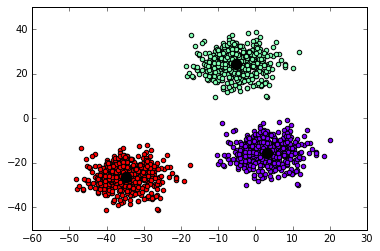

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


def plotClusters(sampleValues, centroidValues, nSamplesPerCluster):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(centroidValues)))
    for i, centroid in enumerate(centroidValues):
        samples = sampleValues[i * nSamplesPerCluster:(i + 1) * nSamplesPerCluster]
        plt.scatter(samples[:, 0], samples[:, 1], c=colors[i])
        plt.plot(centroid[0], centroid[1], markersize=15, marker='.', color='k', mew=4)
        # plt.plot(centroid[0], centroid[1], markersize=10, marker='x', color='m', mew=5)
    plt.show()


def createSamples(numClusters, numSamplesPerCluster, numFeatures, embiggenFactor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []

    for i in range(numClusters):
        samples = tf.random_normal(
            (numSamplesPerCluster, numFeatures),
            mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i)
        )
        currentCentroid = (np.random.random((1, numFeatures)) * embiggenFactor) - (embiggenFactor / 2)
        centroids.append(currentCentroid)
        samples += currentCentroid
        slices.append(samples)

    samples = tf.concat(slices, 0, name="samples")
    centroids = tf.concat(centroids, 0, name="centroids")

    return centroids, samples


nFeatures = 2
nClusters = 3
nSamplesPerCluster = 500
seed = 100
embiggenFactor = 70

np.random.seed(seed)

centroids, samples = createSamples(nClusters, nSamplesPerCluster, nFeatures, embiggenFactor, seed)

model = tf.global_variables_initializer()

with tf.Session() as session:
    samplesValues = session.run(samples)
    centroidValues = session.run(centroids)

centroidValues

plotClusters(samplesValues, centroidValues, nSamplesPerCluster)



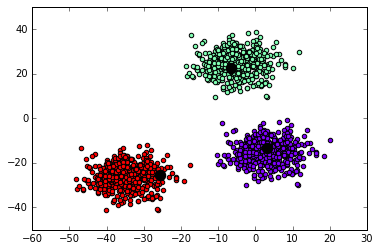

In [40]:
#  Initialisation

def chooseRandomCentroid(samples, nClusters):
    nSamples = tf.shape(samples)[0]
    randomSlices = tf.random_shuffle(tf.range(0, nSamples))
    begin = [0, ]
    size = [nClusters, ]
    centroidIndices = tf.slice(randomSlices, begin, size)
    initialCentroids = tf.gather(samples, centroidIndices)
    return initialCentroids

def assignNearest(samples, centroids):
    expandedVectors = tf.expand_dims(samples, 0)
    expandedCentroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum(tf.square(tf.subtract(expandedVectors, expandedCentroids)), 2)
    return tf.argmin(distances, 0)

def updateCentroids(samples, nearestIndices, nClusters):
    nearestIndices = tf.to_int32(nearestIndices)
    partitions = tf.dynamic_partition(samples, nearestIndices, nClusters)
    return tf.concat([tf.expand_dims(tf.reduce_mean(partition,0), 0) for partition in partitions], 0)
    
initialCentroids = chooseRandomCentroid(samples, nClusters)
nearestIndices = assignNearest(samples, initialCentroids)
latestCentroid = updateCentroids(samples, nearestIndices, nClusters)

model = tf.global_variables_initializer()

with tf.Session() as session:
    sampleValues = session.run(samples)
    updatedCentroidValues = session.run(latestCentroid)

# updatedCentroidValues

plotClusters(sampleValues, updatedCentroidValues, nSamplesPerCluster)